# **SpaceX  Falcon 9 first stage Landing Prediction**


Several examples of successful and unsuccessful Falcon 9 first stage landing are shown below.

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/landing_1.gif)


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/crash.gif)


----


## 1. Collecting the Data from SpaceX API
- Request to the SpaceX API
- Clean the requested data

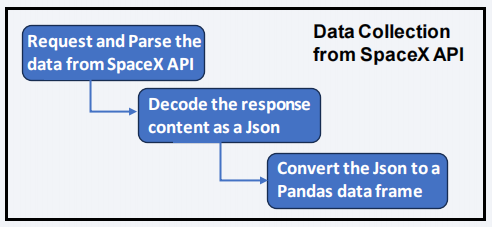

## 1.1. Import Libraries

In [1]:
# import libraries 
import requests
import pandas as pd
import numpy as np
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

##  1.2. Request and Parse Data from SpaceX REST API


In [2]:
# start requesting rocket launch data from SpaceX API with the following URL:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)

In [3]:
# check if the request is successful with the 200 status response code
response.status_code

200

In [4]:
# Use json_normalize meethod to convert the json result into a dataframe
data = pd.json_normalize(response.json())

In [5]:
# check datatype
data.dtypes

static_fire_date_utc          object
static_fire_date_unix        float64
net                             bool
window                       float64
rocket                        object
success                       object
failures                      object
details                       object
crew                          object
ships                         object
capsules                      object
payloads                      object
launchpad                     object
flight_number                  int64
name                          object
date_utc                      object
date_unix                      int64
date_local                    object
date_precision                object
upcoming                        bool
cores                         object
auto_update                     bool
tbd                             bool
launch_library_id             object
id                            object
fairings.reused               object
fairings.recovery_attempt     object
f

In [6]:
# Get the first 3 rows of the dataframe
data.head(3)

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/f9/4a/ZboXReNb_o.png,https://images2.imgbox.com/80/a2/bkWotCIS_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/6c/cb/na1tzhHs_o.png,https://images2.imgbox.com/4a/80/k1oAkY0k_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN


**Note:**
* There are quite some infomation in the raw request response.
* Need to select columns needed.
* Some columns are easy to read such as, <code>static_fire_date_utc</code>, <code>name</code>, but some are hard to understand, such as <code>rocket</code>. 

## 1.3. Define Auxiliary Functions to Help Decode Data with IDs
A lot of the data are IDs in the raw request. For example the <code>rocket</code> column has no information about the rocket just an identification number.

Need to use the API again to get information about the launches using the IDs given for each launch, specifically for columns <code>rocket</code>, <code>payloads</code>, <code>launchpad</code>, and <code>cores</code>.

Define a series of helper functions that will help to use the API to extract information using identification numbers in the launch data.

* From the <code>rocket</code> column we would like to learn the booster name.

In [7]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

* From the <code>launchpad</code> we would like to know the name of the launch site being used, the logitude, and the latitude.


In [8]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

* From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to.


In [9]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

* From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.


In [10]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

## 1.4. Select Features and Decode Data with IDs
In order to predict the outcome of first stage landing, the following information of previous launches is useful:
* launch date
* rocket type 
* rocket payloads
* launching site
* first stage landing outcome

In [11]:
# select a subset of the original dataframe keeping only the features needed.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1, can extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# convert the date_utc to a datetime datatype and then extract the date
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# restrict the dates of the launches to be before Jun. 1st 2022
data = data[data['date'] <= datetime.date(2022, 6, 1)]

# check the first 5 rows of the modified dataframe
data.head()

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",2,2007-03-21T01:10:00.000Z,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",4,2008-09-28T23:15:00.000Z,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",5,2009-07-13T03:35:00.000Z,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",6,2010-06-04T18:45:00.000Z,2010-06-04


Next will use the auxiliary functions defined in the previous section to decode <code>rocket</code>, <code>payloads</code>, <code>launchpad</code> and <code>cores</code>.

In [12]:
# Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [13]:
# Call getBoosterVersion
getBoosterVersion(data)

# Check first 5 items in the list
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [14]:
# Call getLaunchSite
getLaunchSite(data)

# Call getPayloadData
getPayloadData(data)

# Call getCoreData
getCoreData(data)

In [15]:
# create a dictionary for dataframe construction
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


In [16]:
# Create a data from launch_dict
df = pd.DataFrame(launch_dict)

In [17]:
# Show the head of the dataframe
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [18]:
# Check what numbers we have for reusedcount
df['ReusedCount'].value_counts()

0     33
1     25
12    24
9     18
13    11
3     10
5     10
6      8
8      6
2      4
4      4
Name: ReusedCount, dtype: int64

## 1.5. Filter the Dataframe to Only Include `Falcon 9` Launches

After decode the data, now all features are easy to understand. From <code>BoosterVersion</code>, we can tell the data are not limited to `Falcon 9` rockets.

In [19]:
df['BoosterVersion'].unique()

array(['Falcon 1', 'Falcon 9'], dtype=object)

In [20]:
df['BoosterVersion'].value_counts()

Falcon 9    149
Falcon 1      4
Name: BoosterVersion, dtype: int64

In [21]:
# select only Falcon 9 data
data_falcon9 = df[df['BoosterVersion']=='Falcon 9']
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [22]:
print(df.shape)
print(data_falcon9.shape)

(153, 17)
(149, 17)


In [23]:
# reset the FlgihtNumber column
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9.head()

C:\Users\wfei2\AppData\Local\Temp\ipykernel_10796\3002241050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


## 1.6. Export Data

In [24]:
data_falcon9.to_csv('dataset_1.csv', index = False)

In [25]:
data_falcon9.to_excel('dataset_1.xlsx', index = False)